Note: You will need to run this in a seperate editor. The matplotlib.animation package is a bit tricy to get working and depends heavily on your graphics backend. Using the "Automatic" setting on the latest spyder and plotting in a seperate window worked for me. If that doesn't work, email me and I can send you a gif.

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  6 10:59:48 2020

@author: aswart
"""
# python 3 version
import numpy as np
import matplotlib.pyplot as plt

def rk4(x,t,tau,derivsRK,param):
    """
    ##  Runge-Kutta integrator (4th order)
    ## Input arguments -
    ##   x = current value of dependent variable
    ##   t = independent variable (usually time)
    ##   tau = step size (usually timestep)
    ##   derivsRK = right hand side of the ODE; derivsRK is the
    ##             name of the function which returns dx/dt
    ##             Calling format derivsRK(x,t).
    ## Output arguments -
    ##   xout = new value of x after a step of size tau
    """
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,param)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,param)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout

def rka(x,t,tau,err,derivsRK,param):
    """
    ## Adaptive Runge-Kutta routine
    ## Inputs
    ##   x          Current value of the dependent variable
    ##   t          Independent variable (usually time)
    ##   tau        Step size (usually time step)
    ##   err        Desired fractional local truncation error
    ##   derivsRK   Right hand side of the ODE; derivsRK is the
    ##              name of the function which returns dx/dt
    ##              Calling format derivsRK(x,t).
    ## Outputs
    ##   xSmall     New value of the dependent variable
    ##   t          New value of the independent variable
    ##   tau        Suggested step size for next call to rka
    """
    # Set initial variables
    tSave = t;  xSave = x    # Save initial values
    safe1 = .9;  safe2 = 4.  # Safety factors
    eps = np.spacing(1) # smallest value

    # Loop over maximum number of attempts to satisfy error bound
    maxTry = 100

    for iTry in range(1,maxTry):
	
        # Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,param)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,param)
      
        # Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,param)
      
        # Compute the estimated truncation error
        scale = err * (np.abs(xSmall) + np.abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( [np.abs(xDiff)/(scale + eps)] )
        
        #print safe1,tau,errorRatio
      
        # Estimate news tau value (including safety factors)
        tau_old = tau
    
        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = np.max([tau,tau_old/safe2])
        tau = np.min([tau,safe2*tau_old])
  
        # If error is acceptable, return computed values
        if errorRatio < 1 : 
            xSmall = xSmall
            return xSmall, t, tau  

def double_pend(s,t,param):
    """
    Defines the system of diff eqs needed for the double pend problem
    
    """
    theta1 = s[0]
    theta2 = s[1]
    theta1_p = s[2]
    theta2_p = s[3]
    
    L1 = param[0]
    L2 = param[1]
    m2 = 1
    m1 = param[2]
    g = param[3]
    
    a1 = (L2/L1)*(m2/(m1+m2))*np.cos(theta1-theta2)
    a2 = (L1/L2)*np.cos(theta1-theta2)    
    
    F1 = -(L2/L1)*(m2/(m1+m2))*(theta2_p**2)*np.sin(theta1-theta2) - (g/L1)*np.sin(theta1)
    F2 = (L1/L2)*(theta1_p**2)*np.sin(theta1-theta2) - (g/L2)*np.sin(theta2)
    
    g1 = (F1 - a1*F2) / (1 - a1*a2)
    g2 = (F2 - a2*F1) / (1 - a1*a2)
    
    deriv = np.zeros(4)
    deriv[0] = theta1_p
    deriv[1] = theta2_p
    deriv[2] = g1
    deriv[3] = g2
    
    return deriv


def doublepend_data_gen(init_theta1,init_theta2,init_theta1_p,init_theta2_p,param,plotting=False):
    """
    Solves the double pendulum problem
    
    Parameters
    ----------
    init_theta1, init_theta2 : Float
        Inital theta.
    init_theta1_p,init_theta2_p : Float
        Initial theta prime value.
    param : list
        List of model parameter (L1,L2,mr,g).
        Note than we have m1 = mr*m2

    Returns
    -------
    rplot : Numpy array
        Array of r-values used to plot.
    fplot : Numpy array
        Array of f-values used to plot.
    tplot : Numpy array
        Array of time-values used to plot.

    """
    # Set initial state x,y,z and parameters r,sigma,b
    state = np.zeros(4)
    state[0] = float(init_theta1) 
    state[1] = float(init_theta2)
    state[2] = float(init_theta1_p) 
    state[3] = float(init_theta2_p)
        
    # Model paramaters
    L1 = param[0]
    L2 = param[1]
    m2 = 1
    m1 = param[2]
    g = param[3]
    tau = .05      # Initial timestep guess
    err = 1.e-6   # Error tolerance
    
    # Loop over the desired number of steps
    time = 0
    nstep = 2000
    # initialize arrays
    tplot = np.array([]) 
    tauplot = np.array([])
    th1plot = np.array([])
    th2plot = np.array([])
    th1_p_plot = np.array([])
    th2_p_plot = np.array([])    
    
    for istep in range(0,nstep):
        # Record values for plotting
        theta1 = state[0]
        theta2 = state[1]
        theta1_p = state[2]
        theta2_p = state[3]
        
        tplot = np.append(tplot,time)
        tauplot = np.append(tauplot,tau)
        
        th1plot = np.append(th1plot,theta1)
        th2plot = np.append(th2plot,theta2)
        th1_p_plot = np.append(th1_p_plot,theta1_p)
        th2_p_plot = np.append(th2_p_plot,theta2_p)

        #if( istep%50 ==0 ):
          #print('Finished %d steps out of %d '%(istep,nstep))
        # Find new state using Runge-Kutta4
        #state = rk4(state,time,tau,lotka_volterra,param)
        #time += tau
        [state, time, tau] = rka(state,time,tau,err,double_pend,param)
    
    # Print max and min time step returned by rka
    #print('Adaptive time step: Max = %f,  Min = %f '%(max(tauplot[1:]), min(tauplot[1:])));

    
    if plotting:
        # Graph the time series x(t)
        #plt.figure(1)
        #plt.plot(tplot,th1plot)
        #plt.plot(tplot,th2plot)
        #"""
        import matplotlib.animation as animation
        
        # Convert to cartiesian for easier plotting
        x1 = L1*np.sin(th1plot)
        y1 = -L1*np.cos(th1plot)
        x2 = x1 + L2*np.sin(th2plot)
        y2 = y1 - L2*np.cos(th2plot)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-.2, .2), ylim=(-.2, .2))
        ax.set_aspect('equal')
        ax.grid()
        
        line, = ax.plot([], [], 'o-', lw=2)
        time_template = 'time = %.1fs / %.1fs'
        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


        def init():
            line.set_data([], [])
            time_text.set_text('')
            return line, time_text


        def animate(i):
            thisx = [0, x1[i], x2[i]]
            thisy = [0, y1[i], y2[i]]
        
            line.set_data(thisx, thisy)
            time_text.set_text(time_template % (tplot[i],tplot[-1]))
            return line, time_text


        ani = animation.FuncAnimation(fig, animate, range(1, len(y1)),
                                      interval=tplot[-1], blit=True, init_func=init)
        plt.show()
        #"""        
        
    return th1plot,th2plot,th1_p_plot,th2_p_plot,tplot

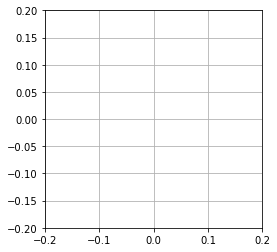

In [5]:
    param = (.1,.1,10,9.81)
    init_theta1 = np.radians(10)
    init_theta2 = np.radians(10)
    init_theta1_p = np.radians(0)
    init_theta2_p = np.radians(0)
    th1plot,th2plot,th1_p_plot,th2_p_plot,tplot = doublepend_data_gen(init_theta1,init_theta2,init_theta1_p,init_theta2_p,param,True)